# Label Type Detection
Train a model that can predict the label captured in a representitive image: phase, nuclear, fluorescent cytoplasm.

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/deepcell-tf')
!ls
!python setup.py build_ext --inplace
!pip install -r requirements.txt

In [0]:
import os
import errno

import numpy as np

import deepcell

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Set up some global constants and shared filepaths

SEED = 213  # random seed for splitting data into train/test

# ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
ROOT_DIR = '/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/LABELTYPE-DETECTION/'

# DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
DATA_DIR = '/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/'
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models'))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs'))

MODEL_NAME = 'LabelDetectionModel'

MODEL_PATH = os.path.join(MODEL_DIR, MODEL_NAME + '.h5')

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Load the training data

Download data for nuclear, brightfield and fluorescent cytoplasm from `deepcell.datasets` and combine the data into a single training dataset.

The labels for each type of data are as follows:

- Nuclear = 0
- Phase = 1
- Fluorescent Cytoplasm = 2

In [0]:
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split
import numpy as np
from sklearn.model_selection import train_test_split
# np.savez('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/example.npz', X=X_train[:100], y=y_train[:100])
training_data = np.load('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/example.npz')
X = training_data['X']
y = training_data['y']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
del X, y
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
nuclear_train = {'X': X_train, 'y': y_train}
nuclear_test = {'X': X_test, 'y': y_test}

X.shape: (90, 216, 256, 1)
y.shape: (90, 216, 256, 1)


Run the following code just when there is enough RAM available

In [0]:
# First, download the data from deepcell.datasets
import deepcell.datasets

# nuclear data (label type 0)
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(seed=SEED)
nuclear_train = {'X': X_train, 'y': y_train}
nuclear_test = {'X': X_test, 'y': y_test}

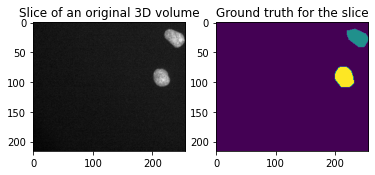

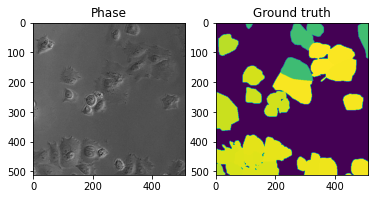

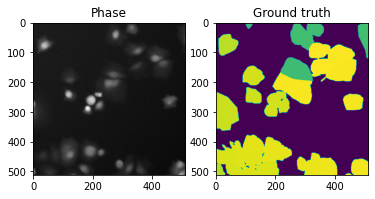

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(nuclear_train['X'][10,:,:,0], cmap='gray')
plt.title('Slice of an original 3D volume')
plt.subplot(1,2,2)
plt.imshow(nuclear_train['y'][10,:,:,0])
plt.title('Ground truth for the slice')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(brightfield_train['X'][10,:,:,0], cmap='gray')
plt.title('Phase')
plt.subplot(1,2,2)
plt.imshow(brightfield_train['y'][10,:,:,0])
plt.title('Ground truth')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(flourescent_train['X'][10,:,:,0], cmap='gray')
plt.title('Phase')
plt.subplot(1,2,2)
plt.imshow(flourescent_train['y'][10,:,:,0])
plt.title('Ground truth')
plt.show()

In [0]:
import numpy as np
np.savez('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/example_phase.npz', X=X_train[:100], y=y_train[:100])
training_data = np.load('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/example_phase.npz')
X = training_data['X']
y = training_data['y']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
brightfield_train = {'X': X_train, 'y': y_train}
brightfield_test = {'X': X_test, 'y': y_test}


Run the following only when enough RAM is available

In [0]:
# brightfield phase data (label type 1)
(X_train, y_train), (X_test, y_test) = deepcell.datasets.phase.hela_s3.load_data(seed=SEED)
brightfield_train = {'X': X_train, 'y': y_train}
brightfield_test = {'X': X_test, 'y': y_test}

In [0]:
import numpy as np
# np.savez('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/example_cytoplasm.npz', X=X_train[:100], y=y_train[:100])
training_data = np.load('/content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/example_cytoplasm.npz')
X = training_data['X']
y = training_data['y']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
flourescent_train = {'X': X_train, 'y': y_train}
flourescent_test = {'X': X_test, 'y': y_test}


Run the following only when enough RAM is available

In [0]:
# flourescent cytoplasm data (label type 2)
(X_train, y_train), (X_test, y_test) = deepcell.datasets.cytoplasm.hela_s3.load_data(seed=SEED)
flourescent_train = {'X': X_train, 'y': y_train}
flourescent_test = {'X': X_test, 'y': y_test}

632602624/632595468 [==============================] - 30s 0us/step


In [0]:
# Reshape each dataset to conform to the minimum size of 216
from deepcell.utils.data_utils import reshape_matrix

RESHAPE_SIZE = 216

all_train = [nuclear_train, brightfield_train, flourescent_train]
all_test = [nuclear_test, brightfield_test, flourescent_test]

for train, test in zip(all_train, all_test):
    train['X'], train['y'] = reshape_matrix(train['X'], train['y'], RESHAPE_SIZE)
    test['X'], test['y'] = reshape_matrix(test['X'], test['y'], RESHAPE_SIZE)

Reshaped feature data from (90, 216, 256, 1) to (180, 216, 216, 1)
Reshaped training data from (90, 216, 256, 1) to (180, 216, 216, 1)
Reshaped feature data from (10, 216, 256, 1) to (20, 216, 216, 1)
Reshaped training data from (10, 216, 256, 1) to (20, 216, 216, 1)
Reshaped feature data from (90, 512, 512, 1) to (810, 216, 216, 1)
Reshaped training data from (90, 512, 512, 1) to (810, 216, 216, 1)
Reshaped feature data from (10, 512, 512, 1) to (90, 216, 216, 1)
Reshaped training data from (10, 512, 512, 1) to (90, 216, 216, 1)
Reshaped feature data from (90, 512, 512, 1) to (810, 216, 216, 1)
Reshaped training data from (90, 512, 512, 1) to (810, 216, 216, 1)
Reshaped feature data from (10, 512, 512, 1) to (90, 216, 216, 1)
Reshaped training data from (10, 512, 512, 1) to (90, 216, 216, 1)


In [0]:
import cv2
all_train[0]['X'][10,:,:,0].dtype
cv2.imwrite('.fluorescence.tif',all_train[0]['X'][10,:,:,0])
cv2.imwrite('.phase.tif',all_train[1]['X'][10,:,:,0])
cv2.imwrite('.cytoplasm.tif',all_train[2]['X'][10,:,:,0])
from google.colab import files
files.download('.fluorescence.tif')
files.download('.phase.tif')
files.download('.cytoplasm.tif')

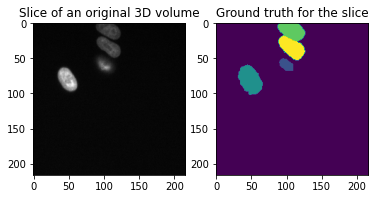

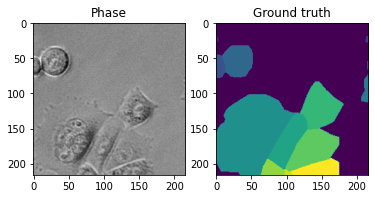

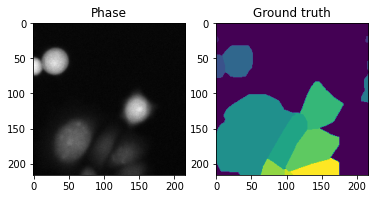

In [0]:
# for train in all_train:
#     print(train['X'].shape)
#     print(train['y'].shape)

import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(all_train[0]['X'][10,:,:,0], cmap='gray')
plt.title('Slice of an original 3D volume')
plt.subplot(1,2,2)
plt.imshow(all_train[0]['y'][10,:,:,0])
plt.title('Ground truth for the slice')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(all_train[1]['X'][10,:,:,0], cmap='gray')
plt.title('Phase')
plt.subplot(1,2,2)
plt.imshow(all_train[1]['y'][10,:,:,0])
plt.title('Ground truth')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(all_train[2]['X'][10,:,:,0], cmap='gray')
plt.title('Phase')
plt.subplot(1,2,2)
plt.imshow(all_train[2]['y'][10,:,:,0])
plt.title('Ground truth')
plt.show()


In [0]:
# Stack up our data as train and test

def make_y(batch, i):
    y = np.zeros((batch, 3))
    y[:, i] = 1
    return y

X_train = np.vstack([
    nuclear_train['X'],
    brightfield_train['X'],
    flourescent_train['X']
])

y_train = np.vstack([
    make_y(nuclear_train['y'].shape[0], 0),
    make_y(brightfield_train['y'].shape[0], 1),
    make_y(flourescent_train['y'].shape[0], 2)
])

X_test = np.vstack([
    nuclear_test['X'],
    brightfield_test['X'],
    flourescent_test['X']
])

y_test = np.vstack([
    make_y(nuclear_test['y'].shape[0], 0),
    make_y(brightfield_test['y'].shape[0], 1),
    make_y(flourescent_test['y'].shape[0], 2)
])

## Create the Label Detection Model

We are using the LabelDetectionModel from `deepcell.applications`

In [0]:
from deepcell.applications import LabelDetectionModel

# set use_pretrained_weights=False to start training from scratch
model = LabelDetectionModel(input_shape=X_train.shape[1:], use_pretrained_weights=False)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 216, 216, 1) 0                                            
__________________________________________________________________________________________________
image_normalization2d (ImageNor (None, 216, 216, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tensor_product (TensorProduct)  (None, 216, 216, 3)  6           image_normalization2d[0][0]      
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 217, 217, 3)  0           tensor_product[0][0]             
______________________________________________________________________________________________

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler
from deepcell import losses


def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
            y_true, y_pred,
            n_classes=len(np.unique(y_train)))


n_epoch = 20  # Number of training epochs
lr = 1e-3
optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=lr, decay=0.9)
batch_size = 32

model.compile(optimizer, loss=loss_function, metrics=['accuracy'])

## Train model

In [0]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# Initialize data generators for training
generator = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=(0.5, 2))

val_generator = ImageDataGenerator()  # No augmentation for validation data

In [0]:
from tensorflow.python.keras import callbacks

model.fit_generator(
    generator.flow(X_train, y_train, batch_size=batch_size), 
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_generator.flow(X_test, y_test, batch_size=batch_size),
    validation_steps=X_test.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            MODEL_PATH,
            monitor='val_loss',
            verbose=1,
            save_best_only=True),
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10
        )
    ]
)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 6/56 [==>...........................] - ETA: 2:07 - loss: 1.4194 - acc: 0.4531
Epoch 00001: val_loss improved from inf to 1.41937, saving model to /content/drive/My Drive/Projectos/3D-PROTUCEL/Code/DEEPCELL/LABELTYPE-DETECTION/models/LabelDetectionModel.h5
56/56 [==============================] - 520s 9s/step - loss: 0.7890 - acc: 0.7517 - val_loss: 1.4194 - val_acc: 0.4531
Epoch 2/20
 6/56 [==>...........................] - ETA: 1:57 - loss: 1.4215 - acc: 0.4531
Epoch 00002: val_loss did not improve from 1.41937
56/56 [==============================] - 497s 9s/step - loss: 0.5161 - acc: 0.8484 - val_loss: 1.4215 - val_acc: 0.4531
Epoch 3/20
 4/56 [=>............................] - ETA: 7:44 - loss: 0.4916 - acc: 0.8359

KeyboardInterrupt: ignored

In [0]:
model.output

<tf.Tensor 'activation/Softmax:0' shape=(?, 3) dtype=float32>

## Export model to TF saved model so it is possible to export it to DeepImageJ

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
#If the model has only one input it can be converted
OUTPUT_DIR = "./saved_model"

builder = tf.saved_model.builder.SavedModelBuilder(OUTPUT_DIR)

signature = tf.saved_model.signature_def_utils.predict_signature_def(
            inputs  = {'input':  model.input},
            outputs = {'output': model.output})
signature_def_map = { tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature }

builder.add_meta_graph_and_variables(K.get_session(), [tf.saved_model.tag_constants.SERVING],
                                             signature_def_map=signature_def_map)
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


Using TensorFlow backend.


INFO:tensorflow:SavedModel written to: ./saved_model/saved_model.pb


b'./saved_model/saved_model.pb'

In [0]:
# Check if the folder has been properly created
!ls -l

total 51
drwx------  4 root root  4096 Apr 13 13:09 build
-rw-------  1 root root  3353 Apr  7 09:19 CODE_OF_CONDUCT.md
-rw-------  1 root root  3518 Apr  7 09:19 CONTRIBUTING.md
drwx------ 10 root root  4096 Apr  7 09:19 deepcell
-rw-------  1 root root  1406 Apr  7 09:19 Dockerfile
drwx------  4 root root  4096 Apr  7 09:19 docs
-rw-------  1 root root 11639 Apr  7 09:19 LICENSE
-rw-------  1 root root   688 Apr  7 09:19 pytest.ini
-rw-------  1 root root  6387 Apr  7 09:19 README.md
-rw-------  1 root root    98 Apr  7 09:19 requirements-test.txt
-rw-------  1 root root   302 Apr  7 09:19 requirements.txt
drwx------  3 root root  4096 Apr 29 18:34 saved_model
drwx------  8 root root  4096 Apr  7 09:19 scripts
-rw-------  1 root root  2436 Apr  7 09:19 setup.py


In [0]:
# Zip folder with the save model
from google.colab import files

!zip saved_model -r saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/variables/variables.index (deflated 68%)
  adding: saved_model/saved_model.pb (deflated 92%)


In [0]:
# Check if the file is there
!ls -l

total 18835
drwx------  4 root root     4096 Apr 13 13:09 build
-rw-------  1 root root     3353 Apr  7 09:19 CODE_OF_CONDUCT.md
-rw-------  1 root root     3518 Apr  7 09:19 CONTRIBUTING.md
drwx------ 10 root root     4096 Apr  7 09:19 deepcell
-rw-------  1 root root     1406 Apr  7 09:19 Dockerfile
drwx------  4 root root     4096 Apr  7 09:19 docs
-rw-------  1 root root    11639 Apr  7 09:19 LICENSE
-rw-------  1 root root      688 Apr  7 09:19 pytest.ini
-rw-------  1 root root     6387 Apr  7 09:19 README.md
-rw-------  1 root root       98 Apr  7 09:19 requirements-test.txt
-rw-------  1 root root      302 Apr  7 09:19 requirements.txt
drwx------  3 root root     4096 Apr 29 18:34 saved_model
-rw-------  1 root root 19233925 Apr 29 18:34 saved_model.zip
drwx------  8 root root     4096 Apr  7 09:19 scripts
-rw-------  1 root root     2436 Apr  7 09:19 setup.py


In [0]:
# And download!
files.download("saved_model.zip")

## Test model predictions

In [0]:
from sklearn.metrics import confusion_matrix

Y = []
Y_pred = []

val_data = val_generator.flow(X_test, y_test, batch_size=1)

for i in range(1000):
    if i % 100 == 0:
        print(".", end="")

    lst, y_true = val_data.next()
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(model.predict(lst), axis=-1)
    Y.append(y_true)
    Y_pred.append(y_pred)
    
Y = np.concatenate(Y, axis=0)
Y_pred = np.concatenate(Y_pred, axis=0)

print("")
cm = confusion_matrix(Y, Y_pred)
print(cm)

..........
[[  0   0 100]
 [  0   0 450]
 [  0   0 450]]
